# LLF_tidy_images - Extended Recruitment Experiment

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

from proglearn.forest import LifelongClassificationForest
from sklearn.model_selection import train_test_split

## FTE/BTE Experiment

### Check Imports

In [2]:
dataset_name = "food_101_array_data_x_1"
load = np.load(dataset_name + '.npz')

print(load['arr_0'][0].shape)
print(len(load['arr_0']))

(32, 32, 3)
34000


In [3]:
dataset_name = "dtd_array_data_x"
load = np.load(dataset_name + '.npz')

print(load['arr_0'][0].shape)
print(len(load['arr_0']))

(32, 32, 3)
4800


In [4]:
dataset_name = '101_ObjectCategories'
load = np.load(dataset_name + '.npz')

print(load['imgs'][0].shape)
print(len(load['imgs']))
print(len(load['lbls']))

(32, 32, 3)
9144
9144


In [5]:
labels = pd.Index(load['lbls'])
labels.value_counts()

16    800
79    798
91    467
44    435
95    435
     ... 
39     34
71     34
74     33
98     32
96     31
Length: 102, dtype: int64

In [6]:
labels.value_counts()[labels.value_counts()>=50]

16    800
79    798
91    467
44    435
95    435
     ... 
69     52
8      51
33     51
42     50
68     50
Length: 68, dtype: int64

### Preprocess Data

In [3]:
data = []
labels = []

# import datasets that emily preprocessed
for set1 in ['101_ObjectCategories', 'CIFAR_10', 'CIFAR_100']:
    # load from npz
    load = np.load(set1 + '.npz')
    # reformat and append
    data.append(load['imgs'].reshape(len(load['imgs']), -1).astype(np.uint8))
    labels.append(load['lbls'].astype(np.uint16))

# import datasets that rahul preprocessed
food_101 = np.empty((0,32*32*3), np.uint8)
for set2 in ['food_101_array_data_x_1', 'food_101_array_data_x_2', 'food_101_array_data_x_3']:
    # load from npz
    load = np.load(set2 + '.npz')
    # reformat and append
    food_101 = np.vstack((food_101,load['arr_0'].reshape(len(load['arr_0']), -1).astype(np.uint8)))
data.append(food_101)
labels.append(np.concatenate([([i]*1000) for i in list(range(100))], axis=0).astype(np.uint16))
# load from npz
load = np.load('dtd_array_data_x.npz')
# reformat and append
data.append(load['arr_0'].reshape(len(load['arr_0']), -1).astype(np.uint8))
labels.append(np.concatenate([([i]*120) for i in list(range(40))], axis=0).astype(np.uint16))
labels

[array([  0,   0,   0, ..., 101, 101, 101], dtype=uint16),
 array([6, 9, 9, ..., 5, 1, 7], dtype=uint16),
 array([19, 29,  0, ..., 51, 42, 70], dtype=uint16),
 array([ 0,  0,  0, ..., 99, 99, 99], dtype=uint16),
 array([ 0,  0,  0, ..., 39, 39, 39], dtype=uint16)]

In [4]:
# modify labels
labels2 = []
for idx, lbl_set in enumerate(labels):
    if idx == 0:
        labels2.append(labels[idx])
    else:
        counter = 0
        for i in range(idx):
            counter += len(np.unique(labels[i]))
        labels2.append(labels[idx] + counter)
labels = labels2
labels

[array([  0,   0,   0, ..., 101, 101, 101], dtype=uint16),
 array([108, 111, 111, ..., 107, 103, 109], dtype=uint16),
 array([131, 141, 112, ..., 163, 154, 182], dtype=uint16),
 array([212, 212, 212, ..., 311, 311, 311], dtype=uint16),
 array([312, 312, 312, ..., 351, 351, 351], dtype=uint16)]

### FTE/BTE Experiment

In [5]:
##### MAIN HYPERPARAMS ##################
model = "uf"
num_tasks = 5
num_trees = 10
num_points_per_task = 500 #5000 # per dataset
reps = 5 #30
#########################################

#### Run Experiment

In [6]:
x_data = data
y_data = labels

In [7]:
# initialize list for storing results
accuracies_across_tasks = []

# format data
if model == 'dnn': # add dnn implementation in the future
    x = x_data
    y = y_data
elif model == 'uf':
    x = x_data #.reshape(len(x_data),-1)
    y = y_data

# get y values per task
ys_by_task = [np.unique(i) for i in labels]

# run experiment over all reps
for rep in range(reps):
    print('Starting rep', rep)
    
    train_x_task = []
    train_y_task = []
    test_x_task = []
    test_y_task = []
    
    # sample num_points_per_task from each dataset
    x_sample = []
    y_sample = []
    for dataset, label in zip(x, y):
        sample = np.random.choice(len(dataset), num_points_per_task)
        x_sample.append(dataset[sample])
        y_sample.append(label[sample])
    
    # initialize overall learner
    learner = LifelongClassificationForest(default_n_estimators=num_trees, default_max_depth=30)

    # for each task
    for task in range(num_tasks):
        print('task', task)

        # get train/test data 
        tr_x, te_x, tr_y, te_y = train_test_split(x_sample[task], y_sample[task], test_size=0.2)
        train_x_task.append(tr_x)
        train_y_task.append(tr_y)
        test_x_task.append(te_x)
        test_y_task.append(te_y)
        
        # predict on single task (UF learner) - CHANGE TO UNCERTAINTYFOREST LATERS
        uf_learner = LifelongClassificationForest(default_n_estimators=num_trees, default_max_depth=30)
        uf_learner.add_task(train_x_task[task], train_y_task[task])
        uf_predictions = uf_learner.predict(test_x_task[task], task_id=0)
        accuracies_across_tasks.append(np.mean(uf_predictions == test_y_task[task]))
        
        # feed to overall learner 
        learner.add_task(train_x_task[task], train_y_task[task])

        # evaluate for other tasks
        for other_task in range(num_tasks):

            if other_task > task:
                pass

            else:
                # predict on current task using other tasks
                prev_task_predictions = learner.predict(test_x_task[other_task], task_id=other_task)
                accuracies_across_tasks.append(np.mean(prev_task_predictions == test_y_task[other_task]))
        
# average results
accuracy_all_task = np.array(accuracies_across_tasks).reshape((reps, -1))
accuracy_all_task = np.mean(accuracy_all_task, axis = 0)

Starting rep 0
task 0
task 1
task 2
task 3
task 4
Starting rep 1
task 0
task 1
task 2
task 3
task 4
Starting rep 2
task 0
task 1
task 2
task 3
task 4
Starting rep 3
task 0
task 1
task 2
task 3
task 4
Starting rep 4
task 0
task 1
task 2
task 3
task 4


In [8]:
accuracy_all_task

array([0.33 , 0.336, 0.24 , 0.34 , 0.258, 0.052, 0.338, 0.28 , 0.06 ,
       0.018, 0.34 , 0.284, 0.054, 0.022, 0.102, 0.332, 0.258, 0.072,
       0.028, 0.13 ])

In [ ]:
# # run experiment over all reps
# for rep in range(reps):
#     print('Starting rep', rep)

#     # for each task
#     for task in range(num_tasks):

#         # initialize progressive learner
#         learner = LifelongClassificationForest(default_n_estimators=ntrees) #default_max_depth=np.ceil(np.log2(num_points_per_task))

#         # get train/test data (train = num_points_per_task)
#         index = np.where(np.in1d(y, ys_by_task[task]))
#         x_task0 = x[index]
#         y_task0 = y[index]
#         train_x_task0, test_x_task0, train_y_task0, test_y_task0 = train_test_split(x_task0, y_task0, test_size=0.25)
#         train_x_task0 = train_x_task0[:num_points_per_task]
#         train_y_task0 = train_y_task0[:num_points_per_task]

#         # feed to learner and predict on single task
#         learner.add_task(train_x_task0, train_y_task0)
#         task_0_predictions = learner.predict(test_x_task0, task_id=task)
#         accuracies_across_tasks.append(np.mean(task_0_predictions == test_y_task0))

#         # evaluate for other tasks
#         for other_task in range(num_tasks):

#             if other_task == task:
#                 pass

#             else:

#                 # get train/test data (train = num_points_per_task)
#                 index = np.random.choice(np.where(np.in1d(y, ys_by_task[other_task]))[0], num_points_per_task, replace=False)
#                 train_x = x[index]
#                 train_y = y[index]

#                 # add transformer from other tasks
#                 learner.add_task(train_x, train_y)

#             # predict on current task using other tasks
#             prev_task_predictions = learner.predict(test_x_task0, task_id=other_task)
#             accuracies_across_tasks.append(np.mean(prev_task_predictions == test_y_task0))

# # average results
# accuracy_all_task = np.array(accuracies_across_tasks).reshape((reps, -1))
# accuracy_all_task = np.mean(accuracy_all_task, axis = 0)

In [34]:
# accuracy
err = [[] for i in range(num_tasks)]
for i in range(num_tasks):
    for j in range(i, num_tasks):
        err[i].append(1-accuracy_all_task[np.sum(list(range(1,j+2)))+i])

# backwards transfer efficiency
bte = [[] for i in range(num_tasks)]
for i in range(num_tasks):
    for j in range(i, num_tasks):
        err_up_to_taskt = 1-accuracy_all_task[np.sum(list(range(1,i+2)))+i]
        err_all_seen =    1-accuracy_all_task[np.sum(list(range(1,j+2)))+i]
        bte[i].append(err_up_to_taskt/err_all_seen)

# forwards transfer efficiency
fte = [[] for i in range(num_tasks)]
for i in range(num_tasks):
    err_taskt_only =  1-accuracy_all_task[np.sum(list(range(1,i+2)))-1]
    err_up_to_taskt = 1-accuracy_all_task[np.sum(list(range(1,i+2)))+i]
    fte[i].append(err_taskt_only/err_up_to_taskt)

# transfer efficiency
te = [[] for i in range(num_tasks)]
for i in range(num_tasks):
    for j in range(i, num_tasks):
        err_taskt_only =  1-accuracy_all_task[np.sum(list(range(1,i+2)))-1]
        err_all_seen =    1-accuracy_all_task[np.sum(list(range(1,j+2)))+i]
        te[i].append(err_taskt_only/err_all_seen)

In [35]:
fte

[[1.0090361445783134],
 [1.0242587601078168],
 [1.0085106382978724],
 [1.0040899795501022],
 [1.0321839080459771]]

In [36]:
bte

[[1.0,
  1.006060606060606,
  1.0030211480362536,
  1.0060606060606059,
  0.9940119760479041],
 [1.0, 1.0305555555555557, 1.0363128491620113, 1.0],
 [1.0, 0.9936575052854123, 1.0129310344827585],
 [1.0, 1.0061728395061729],
 [1.0]]

In [37]:
te

[[1.0090361445783134,
  1.0151515151515151,
  1.012084592145015,
  1.015151515151515,
  1.0029940119760479],
 [1.0242587601078168,
  1.0555555555555556,
  1.0614525139664805,
  1.0242587601078168],
 [1.0085106382978724, 1.0021141649048626, 1.0215517241379308],
 [1.0040899795501022, 1.0102880658436215],
 [1.0321839080459771]]

In [38]:
err

[[0.6639999999999999, 0.6599999999999999, 0.662, 0.66, 0.6679999999999999],
 [0.742, 0.72, 0.716, 0.742],
 [0.94, 0.946, 0.928],
 [0.978, 0.972],
 [0.87]]

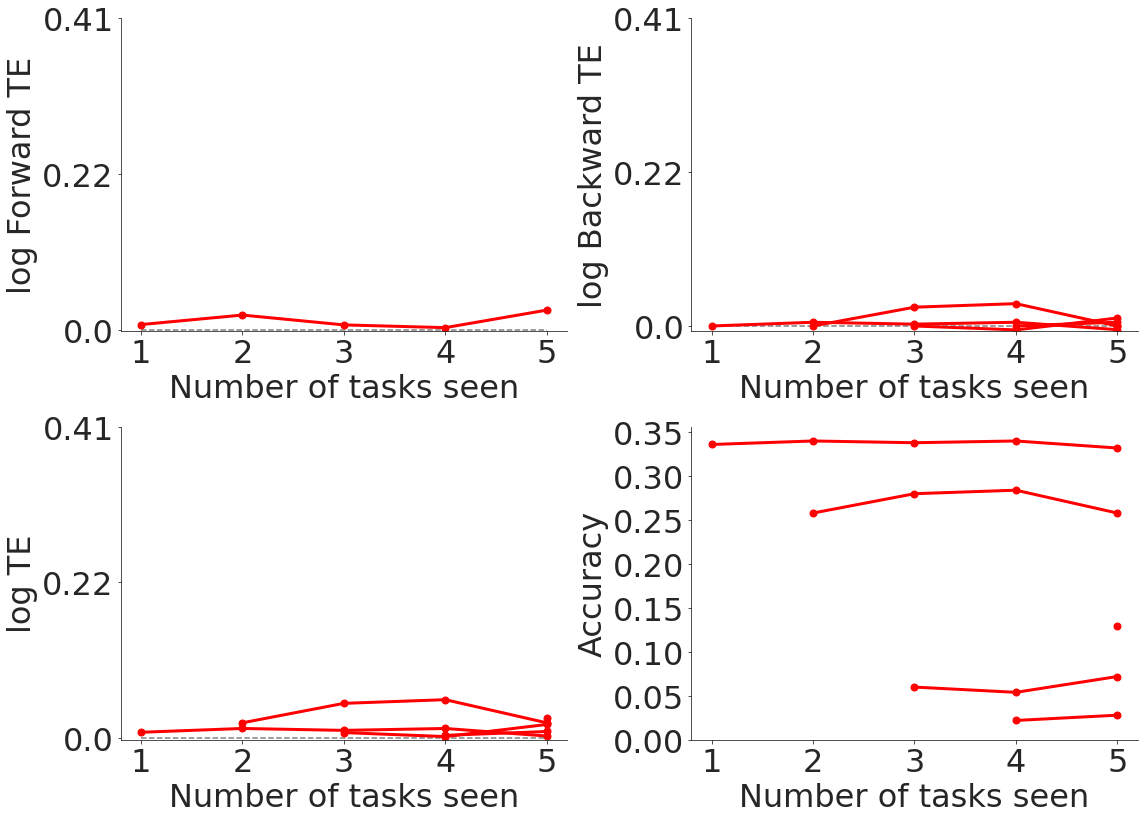

In [42]:
# set figure parameters and plot results 
sns.set_style('ticks')
clr = ["#e41a1c", "#a65628", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#CCCC00"]
fontsize=32
ticksize=32

fig, ax = plt.subplots(2,2, figsize=(16,11.5))
sns.despine()
sns.color_palette("Set1")

ax[0][0].plot(np.arange(1,num_tasks+1), fte, c='red', marker='.', markersize=14, linewidth=3)
ax[0][0].hlines(1, 1,num_tasks, colors='grey', linestyles='dashed',linewidth=1.5)
ax[0][0].tick_params(labelsize=ticksize)
ax[0][0].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[0][0].set_ylabel('log Forward TE', fontsize=fontsize)
ax[0][0].set_xticks(list(range(1, num_tasks+1)))
ax[0][0].set_yticks([1,1.25,1.5])
log_lbl = np.round(np.log([1,1.25,1.5]),2)
labels = [item.get_text() for item in ax[0][0].get_yticklabels()]
for ii,_ in enumerate(labels):
    labels[ii] = str(log_lbl[ii])
ax[0][0].set_yticklabels(labels)

for i in range(num_tasks):
    et = np.asarray(bte[i])
    ns = np.arange(i + 1, num_tasks + 1)
    ax[0][1].plot(ns, et, c='red', marker='.', markersize=14, linewidth=3)

ax[0][1].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[0][1].set_ylabel('log Backward TE', fontsize=fontsize)
ax[0][1].tick_params(labelsize=ticksize)
ax[0][1].hlines(1, 1,num_tasks, colors='grey', linestyles='dashed',linewidth=1.5)
ax[0][1].set_xticks(list(range(1, num_tasks+1)))
ax[0][1].set_yticks([1,1.25,1.5])
log_lbl = np.round(np.log([1,1.25,1.5]),2)
labels = [item.get_text() for item in ax[0][1].get_yticklabels()]
for ii,_ in enumerate(labels):
    labels[ii] = str(log_lbl[ii])
ax[0][1].set_yticklabels(labels)

for i in range(num_tasks):
    et = np.asarray(te[i])
    ns = np.arange(i + 1, num_tasks + 1)
    ax[1][0].plot(ns, et, c='red', marker='.', markersize=14, linewidth=3)

ax[1][0].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[1][0].set_ylabel('log TE', fontsize=fontsize)
#ax[1][0].set_xticks(np.arange(1,10))
ax[1][0].tick_params(labelsize=ticksize)
ax[1][0].hlines(1, 1,num_tasks, colors='grey', linestyles='dashed',linewidth=1.5)
ax[1][0].set_xticks(list(range(1, num_tasks+1)))
ax[1][0].set_yticks([1,1.25,1.5])
log_lbl = np.round(np.log([1,1.25,1.5]),2)
labels = [item.get_text() for item in ax[1][0].get_yticklabels()]
for ii,_ in enumerate(labels):
    labels[ii] = str(log_lbl[ii])
ax[1][0].set_yticklabels(labels)

for i in range(num_tasks):
    et = np.asarray(err[i])
    ns = np.arange(i + 1, num_tasks + 1)
    ax[1][1].plot(ns, 1-et , c='red', marker='.', markersize=14, linewidth=3)

ax[1][1].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[1][1].set_ylabel('Accuracy', fontsize=fontsize)
ax[1][1].tick_params(labelsize=ticksize)
ax[1][1].set_xticks([1,2,3,4,5])
ax[1][1].set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35])

#fig.suptitle("Transfer Efficiency Between MNIST and Fashion-MNIST", fontsize=36)
plt.tight_layout()